In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, det_curve, precision_recall_curve, confusion_matrix, classification_report
from matplotlib.ticker import FuncFormatter
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df1 = pd.read_csv('givemesomecredit.csv')
df1.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
df1.columns = df1.columns.str.strip().str.replace(' ', '_').str.lower()
df1.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   unnamed:_0                            150000 non-null  int64  
 1   seriousdlqin2yrs                      150000 non-null  int64  
 2   revolvingutilizationofunsecuredlines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   numberoftime30-59dayspastduenotworse  150000 non-null  int64  
 5   debtratio                             150000 non-null  float64
 6   monthlyincome                         120269 non-null  float64
 7   numberofopencreditlinesandloans       150000 non-null  int64  
 8   numberoftimes90dayslate               150000 non-null  int64  
 9   numberrealestateloansorlines          150000 non-null  int64  
 10  numberoftime60-89dayspastduenotworse  150000 non-null  int64  
 11  

In [4]:
df1 = df1.drop('unnamed:_0', axis=1)

df1 = df1.rename(columns={
                         'seriousdlqin2yrs': 'default',
                         'revolvingutilizationofunsecuredlines': 'unsec_lines'
})

In [5]:
df1.describe().round(2)

,default,unsec_lines,age,numberoftime30-59dayspastduenotworse,debtratio,monthlyincome,numberofopencreditlinesandloans,numberoftimes90dayslate,numberrealestateloansorlines,numberoftime60-89dayspastduenotworse,numberofdependents
count,150000.00,150000.00,150000.00,150000.00,150000.00,120269.00,150000.00,150000.00,150000.00,150000.00,146076.00
mean,0.07,6.05,52.30,0.42,353.01,6670.22,8.45,0.27,1.02,0.24,0.76
std,0.25,249.76,14.77,4.19,2037.82,14384.67,5.15,4.17,1.13,4.16,1.12
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.03,41.00,0.00,0.18,3400.00,5.00,0.00,0.00,0.00,0.00
50%,0.00,0.15,52.00,0.00,0.37,5400.00,8.00,0.00,1.00,0.00,0.00
75%,0.00,0.56,63.00,0.00,0.87,8249.00,11.00,0.00,2.00,0.00,1.00
max,1.00,50708.00,109.00,98.00,329664.00,3008750.00,58.00,98.00,54.00,98.00,20.00


In [6]:
dff = df1.copy()

dff['monthlyincome'] = dff['monthlyincome'].fillna(0)
dff['numberofdependents'] = dff['numberofdependents'].fillna(0)
dff = dff[dff['age']>0]

In [7]:
dff['default'].value_counts(normalize=True)* 100

default
0    93.315955
1     6.684045
Name: proportion, dtype: float64

In [8]:
def calc_outliers(data):
    if isinstance(data, pd.Series):
        data = data.to_frame(name=data.name)
    
    outliers = []
    
    for k, v in data.items(): 
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        iqr = q3 - q1 
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        below_outliers = v[v < lower_bound]
        above_outliers = v[v > upper_bound]
        
        total_outliers = len(below_outliers) + len(above_outliers)
        total_data_points = len(v)
        
        below_outliers_pct = len(below_outliers) / total_data_points * 100
        above_outliers_pct = len(above_outliers) / total_data_points * 100
        total_outliers_pct = total_outliers / total_data_points * 100
        
        outliers.append({
            "variable": k,
            "outliers_pct": round(total_outliers_pct, 2),
            "below": round(below_outliers_pct, 2),
            "above": round(above_outliers_pct, 2),
        })
    
    outliers_df = pd.DataFrame(outliers)
    return outliers_df

In [9]:
calc_outliers(dff)

,variable,outliers_pct,below,above
0,default,6.68,0.0,6.68
1,unsec_lines,0.51,0.0,0.51
2,age,0.03,0.0,0.03
3,numberoftime30-59dayspastduenotworse,15.99,0.0,15.99
4,debtratio,20.87,0.0,20.87
5,monthlyincome,2.84,0.0,2.84
6,numberofopencreditlinesandloans,2.65,0.0,2.65
7,numberoftimes90dayslate,5.56,0.0,5.56
8,numberrealestateloansorlines,0.53,0.0,0.53
9,numberoftime60-89dayspastduenotworse,5.07,0.0,5.07


In [10]:
def optimal_binning(data, var_name, target_var_name, max_bins=5, min_samples_leaf=0.05, integer=False):

    X = data[[var_name]].values
    y = data[target_var_name].values

    tree = DecisionTreeClassifier(
        max_leaf_nodes=max_bins,
        min_samples_leaf=min_samples_leaf,
        criterion="entropy"
    )
    tree.fit(X, y)

    thresholds = np.sort(tree.tree_.threshold[tree.tree_.feature != -2])
    bin_edges = [-np.inf] + list(thresholds) + [np.inf]

    if integer:
        bin_edges = [int(np.floor(edge)) if edge != np.inf and edge != -np.inf else edge for edge in bin_edges]

    return bin_edges

In [11]:
def calc_woe_iv(data, binned_var_name, target_var_name):

    val_counts = data.groupby(binned_var_name, observed=True)[target_var_name].value_counts().unstack(fill_value=0)
    
    woe_iv = pd.DataFrame(index=val_counts.index)
    woe_iv['count'] = (val_counts[0] + val_counts[1]) 
    woe_iv['count_pct'] = (val_counts.sum(axis=1) / len(data)) * 100 
    woe_iv['0'] = val_counts[0]
    woe_iv['1'] = val_counts[1]
    woe_iv['woe'] = np.where((val_counts[0] + val_counts[1]) > 0,
                             np.log((val_counts[1] / val_counts[1].sum()) / (val_counts[0] / val_counts[0].sum())),
                             np.nan)
    woe_iv = woe_iv.dropna(subset=['woe'])

    val_counts = val_counts.loc[woe_iv.index]
    total_events = val_counts[1].sum()
    total_non_events = val_counts[0].sum()
    
    woe_iv['iv'] = woe_iv['woe'] * ((val_counts[1] / total_events) - (val_counts[0] / total_non_events))
    woe_iv = woe_iv

    woe_iv['bad_rate'] = (val_counts[1] / ( val_counts[0] + val_counts[1] )*100 ).round(2)
    
    return woe_iv

In [12]:
def combine_woe_iv_tables(data, var_bins_list, target_var_name):

    woe_iv_tables = []
    
    for var_bin in var_bins_list:
        var_name, bins = list(var_bin.items())[0]  
        
        data[var_name] = pd.cut(data[var_name], bins=bins, right=False)
        
        df_woe_iv = calc_woe_iv(data, var_name, target_var_name)
        df_woe_iv.insert(0, "var", var_name)  
        df_woe_iv.insert(1, "bin_range", df_woe_iv.index)  

        woe_iv_tables.append(df_woe_iv.reset_index(drop=True))
    
    combined_woe_iv = pd.concat(woe_iv_tables, ignore_index=True)

    return combined_woe_iv

In [13]:
df_train, df_test = train_test_split(dff, test_size=0.3, random_state=42)

In [14]:
df_train.columns

Index(['default', 'unsec_lines', 'age', 'numberoftime30-59dayspastduenotworse',
       'debtratio', 'monthlyincome', 'numberofopencreditlinesandloans',
       'numberoftimes90dayslate', 'numberrealestateloansorlines',
       'numberoftime60-89dayspastduenotworse', 'numberofdependents'],
      dtype='object')

In [15]:
df_bin = df_train.copy() 
target_var = 'default'

var_bins_list = [
    {"unsec_lines": optimal_binning(df_bin, "unsec_lines", target_var, max_bins=4, min_samples_leaf=0.01)},
    {"age": optimal_binning(df_bin, "age", target_var, max_bins=5, min_samples_leaf=0.01, integer=True)},
    {"numberoftime30-59dayspastduenotworse": [-np.inf, 1, 3, np.inf]},
    {'debtratio': [-np.inf, 5, np.inf]},
    {'monthlyincome': [-np.inf, 5, np.inf]},
    {'numberofopencreditlinesandloans': optimal_binning(df_bin, 'numberofopencreditlinesandloans', 
                                                        target_var, max_bins=3, min_samples_leaf=0.01)},
    {'numberoftimes90dayslate': [-np.inf, 1, 2, np.inf]},
    {'numberrealestateloansorlines': optimal_binning(df_bin, 'numberrealestateloansorlines', 
                                                     target_var, max_bins=4, min_samples_leaf=0.01, integer=True)},
    {'numberoftime60-89dayspastduenotworse': optimal_binning(df_bin, 'numberoftime60-89dayspastduenotworse', 
                                                             target_var, max_bins=4, min_samples_leaf=0.01, integer=True)},
    {'numberofdependents': [-np.inf, 5, np.inf]},
                ]

woe_df = combine_woe_iv_tables(df_bin, var_bins_list, target_var)
woe_df.sort_values(['var', 'bin_range']).round(2)

,var,bin_range,count,count_pct,0,1,woe,iv,bad_rate
4,age,"[-inf, 36.0)",15153,14.43,13406,1747,0.59,0.06,11.53
5,age,"[36.0, 52.0)",36409,34.68,33347,3062,0.24,0.02,8.41
6,age,"[52.0, 57.0)",12437,11.84,11596,841,0.00,0.00,6.76
7,age,"[57.0, 62.0)",11834,11.27,11221,613,-0.28,0.01,5.18
8,age,"[62.0, inf)",29166,27.78,28338,828,-0.91,0.16,2.84
12,debtratio,"[-inf, 5.0)",84186,80.18,78245,5941,0.05,0.00,7.06
13,debtratio,"[5.0, inf)",20813,19.82,19663,1150,-0.21,0.01,5.53
14,monthlyincome,"[-inf, 5.0)",22346,21.28,21121,1225,-0.22,0.01,5.48
15,monthlyincome,"[5.0, inf)",82653,78.72,76787,5866,0.05,0.00,7.10
27,numberofdependents,"[-inf, 5.0)",104282,99.32,97264,7018,-0.00,0.00,6.73


In [16]:
woe_df.groupby('var')['iv'].sum().sort_values(ascending=False).to_frame().round(2)

,iv
var,
unsec_lines,1.08
numberoftimes90dayslate,0.90
numberoftime30-59dayspastduenotworse,0.72
numberoftime60-89dayspastduenotworse,0.57
age,0.25
numberofopencreditlinesandloans,0.09
numberrealestateloansorlines,0.01
monthlyincome,0.01
debtratio,0.01


In [17]:
woe_train = df_train.copy()
woe_test = df_test.copy()

for var in woe_df['var'].unique():

    temp_woe = woe_df[woe_df['var'] == var].copy()
    bin_edges = [interval.left for interval in temp_woe['bin_range']] + [temp_woe['bin_range'].iloc[-1].right]

    woe_train[var] = pd.cut(df_train[var], bins=bin_edges, labels=temp_woe['woe'].values, include_lowest=True)
    woe_test[var] = pd.cut(df_test[var], bins=bin_edges, labels=temp_woe['woe'].values, include_lowest=True)

    woe_train[var] = woe_train[var].astype(float)
    woe_test[var] = woe_test[var].astype(float)

In [18]:
woe_train.corr().round(2)

,default,unsec_lines,age,numberoftime30-59dayspastduenotworse,debtratio,monthlyincome,numberofopencreditlinesandloans,numberoftimes90dayslate,numberrealestateloansorlines,numberoftime60-89dayspastduenotworse,numberofdependents
default,1.00,0.27,0.12,0.25,0.02,0.03,0.10,0.29,0.02,0.21,0.01
unsec_lines,0.27,1.00,0.26,0.21,0.06,0.06,0.26,0.21,0.00,0.15,0.02
age,0.12,0.26,1.00,0.07,0.11,0.12,0.08,0.08,0.00,0.06,0.02
numberoftime30-59dayspastduenotworse,0.25,0.21,0.07,1.00,0.02,0.02,0.05,0.24,0.00,0.29,0.00
debtratio,0.02,0.06,0.11,0.02,1.00,0.94,-0.00,0.00,-0.00,0.01,0.01
monthlyincome,0.03,0.06,0.12,0.02,0.94,1.00,-0.08,-0.01,-0.01,-0.00,0.01
numberofopencreditlinesandloans,0.10,0.26,0.08,0.05,-0.00,-0.08,1.00,0.19,0.01,0.11,0.00
numberoftimes90dayslate,0.29,0.21,0.08,0.24,0.00,-0.01,0.19,1.00,0.01,0.31,0.01
numberrealestateloansorlines,0.02,0.00,0.00,0.00,-0.00,-0.01,0.01,0.01,1.00,0.00,0.00
numberoftime60-89dayspastduenotworse,0.21,0.15,0.06,0.29,0.01,-0.00,0.11,0.31,0.00,1.00,0.01


In [19]:
exog_var = ['unsec_lines'
            ,'numberoftimes90dayslate'
            ,'numberoftime30-59dayspastduenotworse'
            ,'age'
            ]
endog_var = 'default'

X_train = woe_train[exog_var]
y_train = woe_train[endog_var]

X_test = woe_test[exog_var]
y_test = woe_test[endog_var]

train_data = y_train.to_frame().join(X_train, how='inner')
test_data = y_test.to_frame().join(X_test, how='inner')

In [20]:
train_data.corr().round(2)

,default,unsec_lines,numberoftimes90dayslate,numberoftime30-59dayspastduenotworse,age
default,1.00,0.27,0.29,0.25,0.12
unsec_lines,0.27,1.00,0.21,0.21,0.26
numberoftimes90dayslate,0.29,0.21,1.00,0.24,0.08
numberoftime30-59dayspastduenotworse,0.25,0.21,0.24,1.00,0.07
age,0.12,0.26,0.08,0.07,1.00


In [21]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]

vif_data.round(2)

,feature,VIF
0,unsec_lines,1.38
1,numberoftimes90dayslate,1.60
2,numberoftime30-59dayspastduenotworse,1.63
3,age,1.10


In [22]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

result = sm.Logit(y_train, X_train).fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.197247
         Iterations 8
                                    Results: Logit
Model:                     Logit                   Method:                  MLE       
Dependent Variable:        default                 Pseudo R-squared:        0.202     
Date:                      2025-05-26 00:54        AIC:                     41431.5256
No. Observations:          104999                  BIC:                     41479.3341
Df Model:                  4                       Log-Likelihood:          -20711.   
Df Residuals:              104994                  LL-Null:                 -25957.   
Converged:                 1.0000                  LLR p-value:             0.0000    
No. Iterations:            8.0000                  Scale:                   1.0000    
--------------------------------------------------------------------------------------
                                      Coef.  Std.Err.     z     

In [23]:
pred_train = result.predict(X_train)
pred_test = result.predict(X_test)

In [24]:
def roc_det_plots(y_train, pred_train, y_test, pred_test):

    fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(10, 5))
    
    def logit(p):
        return np.log(p / (1 - p))
    
    def logistic(x):
        return 1 / (1 + np.exp(-x))
    
    auc_train = roc_auc_score(y_train, pred_train)
    gini_train = 2 * auc_train - 1

    auc_test = roc_auc_score(y_test, pred_test)
    gini_test = 2 * auc_test - 1
    
    # ROC curve - train data
    fpr, tpr, thresholds = roc_curve(y_train, pred_train)
    ax_roc.plot(fpr, tpr, color='royalblue', 
                label=f'Train (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    
    # ROC curve - test data
    fpr, tpr, thresholds = roc_curve(y_test, pred_test)
    ax_roc.plot(fpr, tpr, color='mediumseagreen', 
                label=f'Test (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    
    ax_roc.plot([0, 1], [0, 1],'r--')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title('ROC curves')
    ax_roc.legend(loc='lower right', frameon=True, framealpha=1, edgecolor='black')
    ax_roc.grid(linestyle="--")
    
    # DET curve - train data
    fpr, fnr, thresholds = det_curve(y_train, pred_train)
    ax_det.plot(logit(fpr), logit(fnr), color='royalblue', label='Train')
    
    # DET curve - test data
    fpr, fnr, thresholds = det_curve(y_test, pred_test)
    ax_det.plot(logit(fpr), logit(fnr), color='mediumseagreen', label='Test')
    
    ax_det.set_xlabel('False Positive Rate')
    ax_det.set_ylabel('False Negative Rate')
    ax_det.set_title('DET curves')
    ax_det.legend(loc='best', frameon=True, framealpha=1, edgecolor='black')
    ax_det.grid(linestyle="--")
    
    specific_probs = np.array([0.001, 0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99, 0.9999])  
    tick_logit_values = logit(specific_probs)  

    ax_det.set_xticks(tick_logit_values)
    ax_det.set_yticks(tick_logit_values)
    
    ax_det.set_xlim([-6, 6])
    ax_det.set_ylim([-6, 6])

    def no_percent_formatter(x, pos):
        return f'{logistic(x):.2f}'

    ax_det.xaxis.set_major_formatter(FuncFormatter(no_percent_formatter))
    ax_det.yaxis.set_major_formatter(FuncFormatter(no_percent_formatter))
    
    plt.tight_layout()
    plt.show()


C:\Users\micha\AppData\Local\Temp\ipykernel_1544\194752987.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.log(p / (1 - p))
C:\Users\micha\AppData\Local\Temp\ipykernel_1544\194752987.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(p / (1 - p))
C:\Users\micha\AppData\Local\Temp\ipykernel_1544\194752987.py:6: RuntimeWarning: divide by zero encountered in divide
  return np.log(p / (1 - p))
C:\Users\micha\AppData\Local\Temp\ipykernel_1544\194752987.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(p / (1 - p))


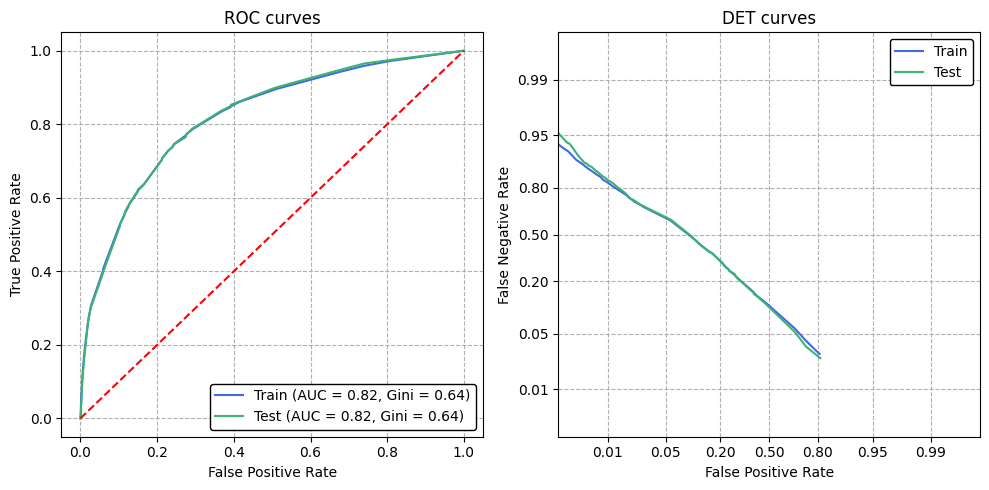

In [25]:
roc_det_plots(y_train, pred_train, y_test, pred_test)

In [26]:
def plot_discrimination_threshold(y_test, pred_test, manual_threshold=None, optimization_metric='f1'):

    precisions_test, recalls_test, thresholds_test = precision_recall_curve(y_test, pred_test)
    f1_scores_test = 2 * (precisions_test * recalls_test) / (precisions_test + recalls_test)
    valid_f1_scores_test = np.nan_to_num(f1_scores_test, nan=0.0, posinf=0.0, neginf=0.0)
    queue_rates_test = [np.mean(pred_test >= threshold) for threshold in thresholds_test]

    plt.figure(figsize=(10, 5))
    plt.plot(thresholds_test, precisions_test[:-1], 'royalblue', linestyle='-', label='Precision')
    plt.plot(thresholds_test, recalls_test[:-1], 'mediumseagreen', linestyle='-', label='Recall')
    plt.plot(thresholds_test, valid_f1_scores_test[:-1], 'red', linestyle='-', label='F1 Score')
    plt.plot(thresholds_test, queue_rates_test, 'mediumvioletred', linestyle='-', label='Queue Rate')

    if manual_threshold is None:
        valid_indices = thresholds_test < 0.8
        valid_thresholds = thresholds_test[valid_indices]
        valid_precisions = precisions_test[:-1][valid_indices]
        valid_recalls = recalls_test[:-1][valid_indices]
        valid_f1_scores = valid_f1_scores_test[:-1][valid_indices]  

        if optimization_metric == 'f1':
            if len(valid_thresholds) > 0:
                max_f1_index = np.argmax(valid_f1_scores)
                disc_threshold = valid_thresholds[max_f1_index]
            else:
                disc_threshold = 0.5  
        elif optimization_metric == 'pr_equal':
            if len(valid_thresholds) > 0:
                
                precision_recall_diff = np.abs(valid_precisions - valid_recalls)
                min_diff_index = np.argmin(precision_recall_diff)
                min_diff_value = precision_recall_diff[min_diff_index]
                
                equal_diff_indices = np.where(precision_recall_diff == min_diff_value)[0]
                
                disc_threshold = valid_thresholds[equal_diff_indices[0]]
            else:
                disc_threshold = 0.5  
        else:
            raise ValueError("Invalid optimization_metric. Choose 'f1' or 'pr_equal'.")
    else:
        disc_threshold = manual_threshold

    plt.axvline(x=disc_threshold, color='k', linestyle='--', label=f'dt optymalne = {disc_threshold:.2f}')

    plt.xlim([0.0, 0.8])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Discrimination Threshold (dt) - próg odcięcia', size=16)
    plt.legend(loc='right', frameon=True, framealpha=1, edgecolor='black')
    plt.grid(linestyle="--")
    plt.show()

    return disc_threshold

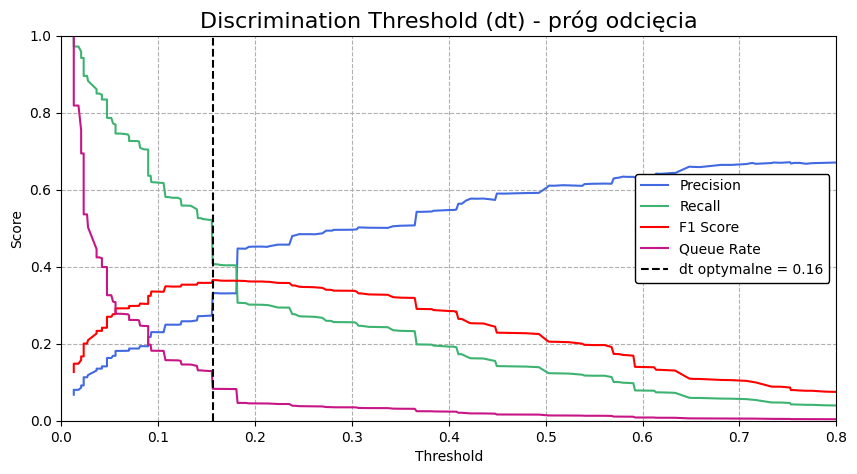

In [27]:
disc_threshold = plot_discrimination_threshold(y_train, pred_train, optimization_metric='f1')

In [28]:
pred_train_binary = (pred_train > disc_threshold).astype(int)
print(pd.DataFrame(confusion_matrix(y_train, pred_train_binary)).round(2))
print(pd.DataFrame(confusion_matrix(y_train, pred_train_binary)/len(y_train)*100).round(2))
print(f"threshold: {disc_threshold}")
print(classification_report(y_train, pred_train_binary), f"threshold: {disc_threshold}")

       0     1
0  92093  5815
1   4206  2885
       0     1
0  87.71  5.54
1   4.01  2.75
threshold: 0.15631505928259545
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     97908
           1       0.33      0.41      0.37      7091

    accuracy                           0.90    104999
   macro avg       0.64      0.67      0.66    104999
weighted avg       0.91      0.90      0.91    104999
 threshold: 0.15631505928259545


In [ ]:
# https://medium.com/@kstarun/k-s-score-for-model-evaluation-5339f0a5c705

class ModelEvaluation:
    
    
    def __init__(self, predictions_df):
        self.predictions = predictions_df

    def compute_gains_table_ks(self):
        
        self.predictions['Bins'] = pd.qcut(self.predictions['PD'], q=10, duplicates='drop').astype(str)
        self.predictions['Total'] = 1
        
        self.predictions.rename(columns={'DV': 'Bads'}, inplace=True)
        
        gains_table = self.predictions[['Bins', 'Bads', 'Total']].groupby('Bins').sum()

        gains_table['Goods'] = gains_table['Total'] - gains_table['Bads']
        gains_table['Cumulative_bads'] = gains_table['Bads'].cumsum()
        gains_table['Cumulative_goods'] = gains_table['Goods'].cumsum()
        gains_table['Cumulative_Bad_Rate'] = (gains_table['Cumulative_bads'] / gains_table['Cumulative_bads'].max())
        gains_table['Cumulative_Good_Rate'] = (gains_table['Cumulative_goods'] / gains_table['Cumulative_goods'].max())
        gains_table['KS'] = abs(gains_table["Cumulative_Bad_Rate"] - gains_table["Cumulative_Good_Rate"])

        gains_table = gains_table[['Bads', 'Goods', 'Total', 'Cumulative_bads', 'Cumulative_goods', 'Cumulative_Bad_Rate', 'Cumulative_Good_Rate', 'KS']]
        model_ks = gains_table['KS'].max()

        first_bin = gains_table.index[0]
        left_edge, right_edge = first_bin[1:].split(', ')  
        new_first_bin = f"[{-np.inf}, {right_edge}"  
        
        last_bin = gains_table.index[-1]
        left_edge, right_edge = last_bin[1:].split(', ') 
        new_last_bin = f"[{left_edge}, {np.inf}]"  

        gains_table.index = [new_first_bin] + list(gains_table.index[1:-1]) + [new_last_bin]
        

        def identify_max(series):
            max_value = series.max()
            return ['<---' if i == max_value else '' for i in series]
    
        def highlight_max(series):
            max_value = series.max()
            return ['background-color: aquamarine' if i == max_value else '' for i in series]
    
        gains_table['Max_KS'] = identify_max(gains_table['KS'])
        gains_table = gains_table.style.apply(highlight_max, subset=['KS'])
        
        return gains_table, model_ks


In [30]:
pdata = pred_train.to_frame().merge(y_train.to_frame(), left_index=True, right_index=True, how='inner')
pdata = pdata.rename(columns={0: 'PD', 'default': 'DV'})

gains_table, ks_value = ModelEvaluation(pdata).compute_gains_table_ks()
gains_table

,Bads,Goods,Total,Cumulative_bads,Cumulative_goods,Cumulative_Bad_Rate,Cumulative_Good_Rate,KS,Max_KS
"[-inf, 0.0178]",292,25491,25783,292,25491,0.041179,0.260357,0.219178,
"(0.0178, 0.0205]",117,6205,6322,409,31696,0.057679,0.323732,0.266054,
"(0.0205, 0.0231]",331,16282,16613,740,47978,0.104358,0.490031,0.385674,
"(0.0231, 0.0276]",245,9220,9465,985,57198,0.138908,0.584201,0.445293,
"(0.0276, 0.042]",190,4718,4908,1175,61916,0.165703,0.632390,0.466687,
"(0.042, 0.056]",627,12115,12742,1802,74031,0.254125,0.756128,0.502003,<---
"(0.056, 0.0897]",777,7660,8437,2579,81691,0.363700,0.834365,0.470664,
"(0.0897, 0.155]",1607,10324,11931,4186,92015,0.590326,0.939811,0.349485,
"[0.155, inf]",2905,5893,8798,7091,97908,1.000000,1.000000,0.000000,


In [31]:
coef_df = pd.DataFrame({
    'var': result.params.index,
    'coef': result.params.values
})
coef_df

,var,coef
0,const,-2.250308
1,unsec_lines,0.774583
2,numberoftimes90dayslate,0.628505
3,numberoftime30-59dayspastduenotworse,0.703534
4,age,0.518305


In [32]:
rows = []

for col in X_train.columns:
    unique_values = sorted(X_train[col].unique())
    
    for i, val in enumerate(unique_values):
        rows.append({'var': col, 'bin': i, 'woe': val})

woe_df = pd.DataFrame(rows)

scorecard = woe_df.merge(coef_df, how='inner', on='var')
scorecard = scorecard[~(scorecard['var']=='const')]

In [33]:
cutoff_odds = (1 - disc_threshold) / disc_threshold
print(f'cutoff odds: {cutoff_odds.round(2)}')

cutoff odds: 5.4


In [34]:
p_double_odds = 50 # points to double odds
factor = p_double_odds/np.log(2)
offset = 400 - factor * np.log(cutoff_odds)
intercept = coef_df[coef_df['var']=='const']['coef'].iloc[0]
n_var = len(coef_df)-1

scorecard['score'] = - (scorecard['woe'] * scorecard['coef'] + intercept/n_var) * factor + offset/n_var 
scorecard['score'] = scorecard['score'].round(0)
scorecard

,var,bin,woe,coef,score
1,unsec_lines,0,-1.275209,0.774583,181.0
2,unsec_lines,1,-0.322841,0.774583,128.0
3,unsec_lines,2,0.566618,0.774583,79.0
4,unsec_lines,3,1.372274,0.774583,34.0
5,numberoftimes90dayslate,0,-0.396599,0.628505,128.0
6,numberoftimes90dayslate,1,1.963829,0.628505,21.0
7,numberoftimes90dayslate,2,2.879673,0.628505,-20.0
8,numberoftime30-59dayspastduenotworse,0,-0.539237,0.703534,138.0
9,numberoftime30-59dayspastduenotworse,1,1.079239,0.703534,55.0
10,numberoftime30-59dayspastduenotworse,2,2.256752,0.703534,-4.0


In [35]:
print(scorecard.loc[scorecard.groupby('var')['bin'].idxmin()]['score'].sum())
print(scorecard.loc[scorecard.groupby('var')['bin'].idxmax()]['score'].sum())

591.0
98.0


In [36]:
score_train = train_data.copy()
score_train = score_train.rename(columns={'default': 'default_act'})

for var in scorecard['var'].unique():
    mapping = scorecard[scorecard['var'] == var].set_index('woe')['score'].to_dict()
    if var in score_train.columns:
        score_train[var] = score_train[var].map(mapping)

score_train['score'] = score_train.drop(columns=['default_act']).sum(axis=1)

score_train = pred_train_binary.to_frame().rename(columns={0:'default_pred'}).join(score_train, how='inner')

In [37]:
score_train.head()

,default_pred,default_act,unsec_lines,numberoftimes90dayslate,numberoftime30-59dayspastduenotworse,age,score
27822,0,0,128.0,128.0,138.0,110.0,504.0
85203,0,0,181.0,128.0,55.0,110.0,474.0
42217,0,0,181.0,128.0,138.0,101.0,548.0
119959,1,0,34.0,-20.0,138.0,110.0,262.0
37678,0,0,181.0,128.0,138.0,144.0,591.0


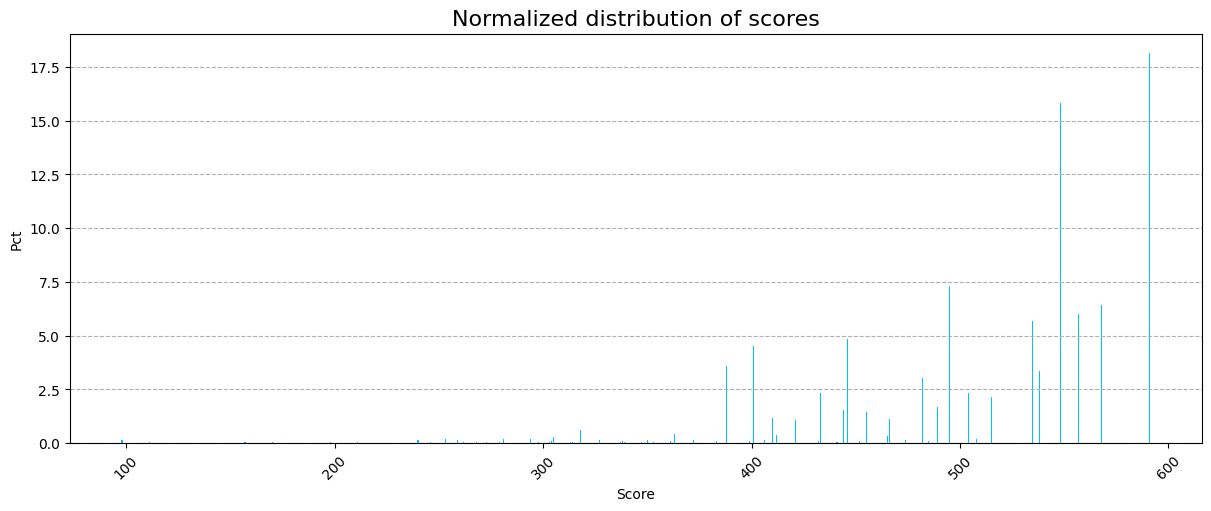

In [39]:
score_dist = score_train['score'].value_counts(normalize=True)*100

plt.figure(figsize=(12, 5), constrained_layout=True)
plt.bar(score_dist.index, score_dist.values, color='deepskyblue', width=0.5)

plt.xlabel('Score')
plt.ylabel('Pct')
plt.title('Normalized distribution of scores', size=16)
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--')

plt.show()